<a href="https://colab.research.google.com/github/BrauuHdzM/BERT-For-Sequence-Classification/blob/master/DaVincisBERTst1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers[torch]

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch.utils.data import Dataset

# Corpus
text_filepath = "/content/train_data.csv"
labels_filepath = "/content/train_labels_subtask_1.csv"

text_data = pd.read_csv(text_filepath, usecols=[1], header=None)
train_texts, test_texts = train_test_split(text_data.iloc[:, 0].tolist(), test_size=0.1, random_state=0)
labels_data = pd.read_csv(labels_filepath, header=None)
train_labels, test_labels = train_test_split(labels_data.iloc[:, 0].tolist(), test_size=0.1, random_state=0)

In [ ]:
# Tokenización y codificación del corpus de entrenamiento y pruebas
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torc
                h.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, train_labels)
test_dataset = CustomDataset(test_encodings, test_labels)

# Carga del modelo preentrenado y ajuste fino
model = BertForSequenceClassification.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')

training_args = TrainingArguments(
    output_dir='./test_trainer',
    evaluation_strategy='epoch'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchi

Epoch,Training Loss,Validation Loss
1,No log,0.256695
2,0.295300,0.254441
3,0.080500,0.377756


TrainOutput(global_step=1011, training_loss=0.18652731775647927, metrics={'train_runtime': 238.0195, 'train_samples_per_second': 33.98, 'train_steps_per_second': 4.248, 'total_flos': 623449867896000.0, 'train_loss': 0.18652731775647927, 'epoch': 3.0})

              precision    recall  f1-score   support

           0       0.96      0.91      0.93       174
           1       0.88      0.95      0.92       126

    accuracy                           0.93       300
   macro avg       0.92      0.93      0.93       300
weighted avg       0.93      0.93      0.93       300



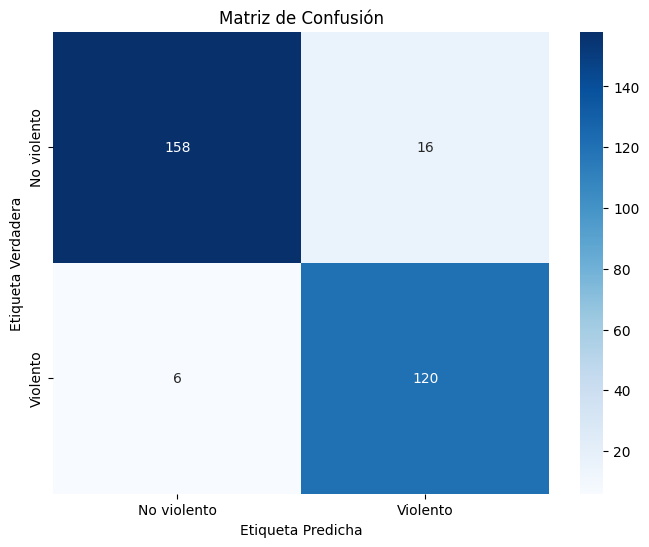

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predecir en el conjunto de prueba
predictions = trainer.predict(test_dataset)

# Las predicciones están en formato logit, así que las convertimos a clases usando argmax
predicted_classes = np.argmax(predictions.predictions, axis=-1)

# Classification report
report = classification_report(test_labels, predicted_classes)
print(report)

# Matriz de confusión
cm = confusion_matrix(test_labels, predicted_classes)
class_labels = ["No violento", "Violento"]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Matriz de Confusión")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Verdadera")
plt.show()